# Homework 4 

Student: Justin Yu

Student Number: 1006747111

**Part 1: Exploring Sample Sizes**

In [1]:
# import packages
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt;
from scipy import stats

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


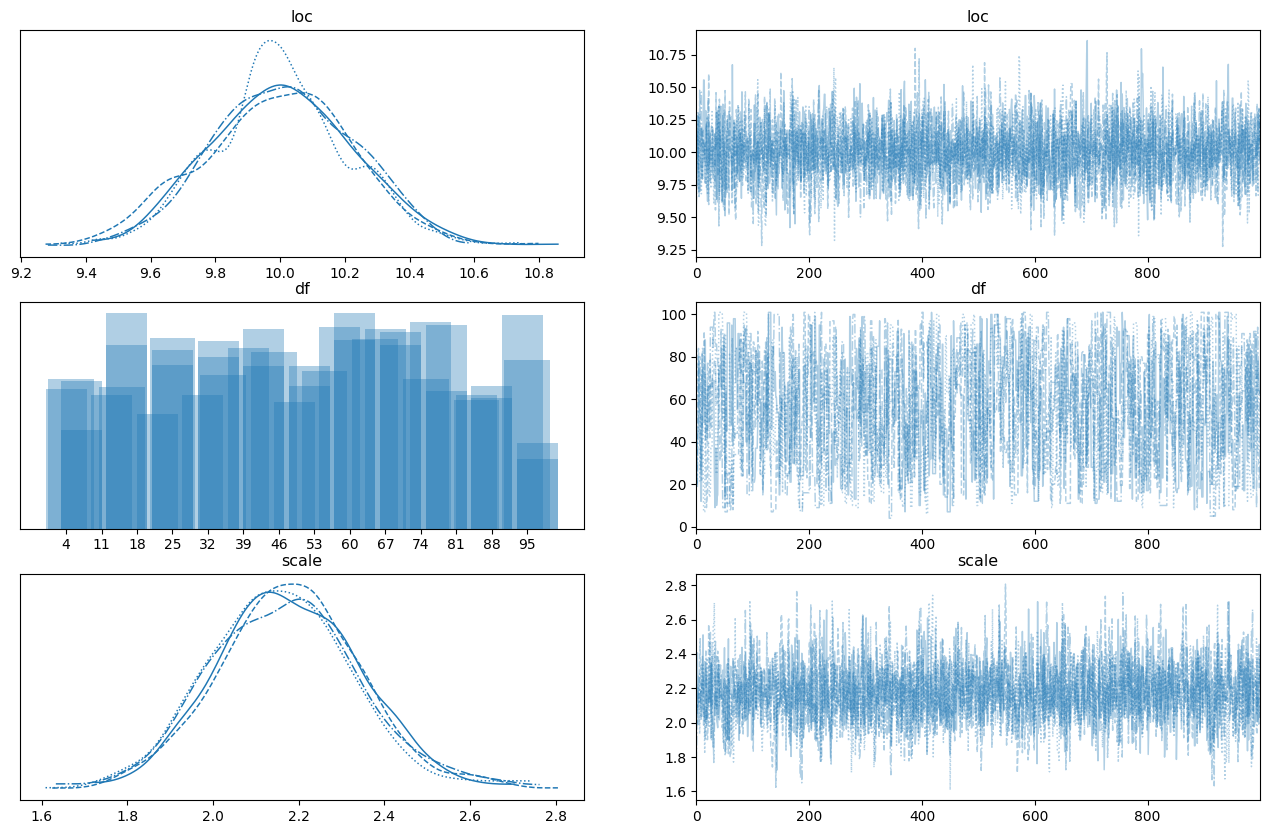

In [27]:
# Setting up parameters
mu_0,sigma_0=0,10
n, loc_true, scale_true, df_true = 100, 10, 2, 15

# Generate Data
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

# Pymc model
toy_model = pm.Model()
with toy_model: 
    loc = pm.Normal("loc", mu=mu_0, sigma=sigma_0)
    scale = pm.HalfNormal("scale", sigma = 5)
    df = pm.DiscreteUniform("df", lower = 1, upper = 101)
                           
    likelihood = pm.StudentT('likelihood', mu=loc, sigma=scale, nu=df, observed=x)

with toy_model:
    idata = pm.sample()

fig,ax = plt.subplots(3,2, figsize=(16,10))
az.plot_trace(idata, axes=ax);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 728 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


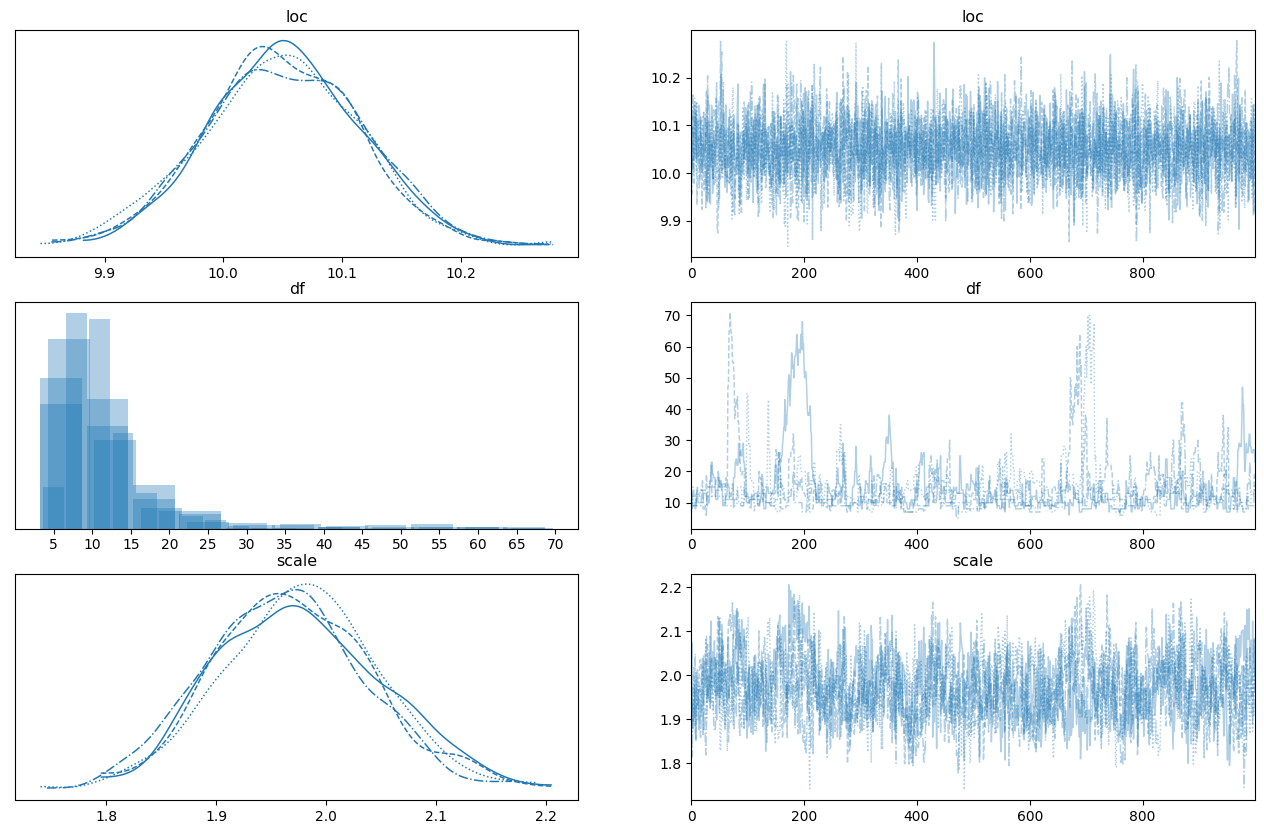

In [53]:
# Setting up parameters
mu_0,sigma_0=0,10
# let n = 1000 since any more takes very long to run
n, loc_true, scale_true, df_true = 1000, 10, 2, 15

# Generate Data
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

# Pymc model
toy_model2 = pm.Model()
with toy_model2: 
    loc = pm.Normal("loc", mu=mu_0, sigma=sigma_0)
    scale = pm.HalfNormal("scale", sigma = 5)
    df = pm.DiscreteUniform("df", lower = 1, upper = 101)
                           
    likelihood = pm.StudentT('likelihood', mu=loc, sigma=scale, nu=df, observed=x)

with toy_model2:
    idata2 = pm.sample()

fig,ax = plt.subplots(3,2, figsize=(16,10))
az.plot_trace(idata2, axes=ax);

We know that the true degrees of freedom is 15. When we run a small sample size of 100, we can see that the diagram of the distribution of our degrees of freedom does not support inference regarding the df parameter $\nu$. However, when we increase the sample size to 1000, although the algorithm takes longer to run, the result is a diagram (that is heavily skewed) which allows for a better inference regarding the df parameter (less spread out). Thus we theorize that as the sample size increases, so would the support for inference regarding the df parameter. Perhaps sample sizes of 10,000 would be enough? 

**Part 2: Posterior Reporting**

In [55]:
# (a) effective sample sizes for smaller sample n
print("number of MCMC samples:", idata.posterior['loc'].values.flatten().shape[-1])
az.summary(idata, round_to=2)

number of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,10.00,0.22,9.60,10.42,0.00,0.00,4079.08,2647.46,1.0
df,54.83,27.08,13.00,101.00,1.07,0.76,625.43,689.55,1.0
scale,2.17,0.17,1.85,2.50,0.00,0.00,2315.70,1994.18,1.0


In [56]:
# (a) effective sample sizes for bigger sample n
print("number of MCMC samples:", idata2.posterior['loc'].values.flatten().shape[-1])
az.summary(idata2, round_to=2)

number of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,10.05,0.06,9.93,10.17,0.00,0.00,3238.49,2524.86,1.00
df,14.02,8.15,7.00,26.00,0.69,0.49,194.59,175.13,1.03
scale,1.97,0.07,1.84,2.12,0.00,0.00,262.17,421.31,1.02


**(a) effective sample sizes:**
A high effective sample size is desirable because it indicates that the MCMC chain has explored the parameter space effectively and that the samples are relatively uncorrelated, leading to more reliable statistical estimates and inferences. We can see that the parameter df is not explored as much as the parameters loc and scale for both models.

**(b) chain convergence measures:**
The rhat of each parameter for the smaller sample size of 100, seems to suggest that the algorithm perfectly converges to the stationary distributions for each parameter. For the larger sample size, we can see that the "loc" or mean parameter converges well to its stationary distribution, however, for the degrees of freedom and scale, we observe rhats above 1.0 which indicate very close to convergence but not perfect. This would explain why the distribution of df does not offer the best support for the inference of df, but as the samples grows, this should lower.

**(c) divergences:**

We can see that both models do not diverge or have not "flown off" the mass of our target distribution, which is good.

In [57]:
# (d) Metropolis-Hastings acceptance rates for smaller sample
print(idata.sample_stats.acceptance_rate.values.flatten())
print("The mean acceptance rate is: ", np.mean(idata.sample_stats.acceptance_rate.values.flatten()))

[1.         0.78452634 0.87965375 ... 0.05344361 0.97933086 0.63080146]
The mean acceptance rate is:  0.8240652050250394


In [58]:
# (d) Metropolis-Hastings acceptance rates for bigger sample
print(idata2.sample_stats.acceptance_rate.values.flatten())
print("The mean acceptance rate is: ", np.mean(idata2.sample_stats.acceptance_rate.values.flatten()))

[0.86927712 0.59086278 0.92648083 ... 0.64268619 1.         0.5671254 ]
The mean acceptance rate is:  0.8280962705543854


**(d) Metropolis-Hastings acceptance rates:**

A mean acceptance rate of 0.82 means that, on average, 82% of proposed moves (transitions from one state to another in the state space) are accepted for both models.

**(e) warnings or concerns from pymc:**

Pymc informed us that that rhat for some of our parameters (scale and df) in the larger sample model are larger than 1.01 (which indicates strong but not perfect convergence).

**Eight Schools Example:**

In [33]:
import logging

# Initiate Parameters
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

_log = logging.getLogger("pymc")
_log.setLevel(logging.INFO)
    

with pm.Model() as Centered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    SEED = [20100420, 20134234]
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 99 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 57 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [63]:
# (a) effective sample sizes for Centered_eight
print("number of MCMC samples:", fit_C.posterior['mu'].values.flatten().shape[-1])
az.summary(fit_C, round_to=2)[['ess_bulk', 'ess_tail']]

number of MCMC samples: 10000


,ess_bulk,ess_tail
mu,973.08,1468.48
theta[0],1053.08,3744.18
theta[1],1444.32,3920.65
theta[2],2472.54,3920.79
theta[3],1986.30,4577.05
theta[4],2187.03,3942.18
theta[5],2135.81,3759.05
theta[6],1051.60,2293.32
theta[7],1567.88,4027.55
tau,317.07,189.23


In [62]:
# (a) effective sample sizes for NonCentered_eight
print("number of MCMC samples:", fit_NC.posterior['mu'].values.flatten().shape[-1])
rows_to_remove = ['theta_t[0]', 'theta_t[1]', 'theta_t[2]', 'theta_t[3]', 'theta_t[4]', 'theta_t[5]', 'theta_t[6]', 'theta_t[7]']
az.summary(fit_NC, round_to=2)[['ess_bulk', 'ess_tail']].drop(index=rows_to_remove, errors='ignore')

number of MCMC samples: 10000


,ess_bulk,ess_tail
mu,8581.13,6505.73
tau,5511.17,4376.91
theta[0],9057.78,6493.66
theta[1],9951.81,6238.65
theta[2],8563.53,6462.90
theta[3],10647.46,7411.60
theta[4],10206.09,7104.32
theta[5],10627.13,7478.53
theta[6],10115.73,6474.04
theta[7],10309.05,7275.09


**(a) effective sample sizes:**
Comparing the bulk effective sample sizes for the centered and non centered models we can see that the Non-centered model shows much higher effective sample sizes for both bulk and tail. This suggests that the samples in non-centered model are much less correlated with each other (i.e. independent). A high effective sample size is desirable because it indicates that the MCMC chain has explored the parameter space effectively and that the samples are relatively uncorrelated, leading to more reliable statistical estimates and inferences. We can see that the parameter tau is not explored as much for both models.

In [61]:
# (b) chain convergence measures for Centered_eight
print("number of MCMC samples:", fit_C.posterior['mu'].values.flatten().shape[-1])
az.summary(fit_C, round_to=2)[['r_hat']]

number of MCMC samples: 10000


,r_hat
mu,1.00
theta[0],1.00
theta[1],1.00
theta[2],1.00
theta[3],1.00
theta[4],1.00
theta[5],1.00
theta[6],1.00
theta[7],1.00
tau,1.01


In [60]:
# (a) chain convergence measures for NonCentered_eight
print("number of MCMC samples:", fit_NC.posterior['mu'].values.flatten().shape[-1])
rows_to_remove = ['theta_t[0]', 'theta_t[1]', 'theta_t[2]', 'theta_t[3]', 'theta_t[4]', 'theta_t[5]', 'theta_t[6]', 'theta_t[7]']
az.summary(fit_NC, round_to=2)[['r_hat']].drop(index=rows_to_remove, errors='ignore')

number of MCMC samples: 10000


,r_hat
mu,1.0
tau,1.0
theta[0],1.0
theta[1],1.0
theta[2],1.0
theta[3],1.0
theta[4],1.0
theta[5],1.0
theta[6],1.0
theta[7],1.0


**(b) chain convergence measures:**
We can see that the rhats are 1.0 for the non-centered eight models. For the centered model, all the parameters except tau have rhat of 1.0. This reflects the lower effective sample size shown for tau in the centered model and implies a lesser perfect convergence to the stationary distribution.

**(c) divergences:**
We can see that the Centered eight schools model caused 184 divergences, but non-centered eight schools model caused only 6 divergences. This suggests that the non-centered parameterization may be more efficient or effective in exploring the parameter space compared to the centered parameterization.

In [64]:
# (d) Metropolis-Hastings acceptance rates for Centered_eight
print(fit_C.sample_stats.acceptance_rate.values.flatten())
print("The mean acceptance rate is: ", np.mean(fit_C.sample_stats.acceptance_rate.values.flatten()))

[0.98029394 0.79170819 0.62643764 ... 0.48638972 0.95749659 0.21846781]
The mean acceptance rate is:  0.7600358994334436


In [65]:
# (d) Metropolis-Hastings acceptance rates for NonCentered_eight
print(fit_NC.sample_stats.acceptance_rate.values.flatten())
print("The mean acceptance rate is: ", np.mean(fit_NC.sample_stats.acceptance_rate.values.flatten()))

[0.92153892 1.         1.         ... 0.73261666 0.28411917 0.94666474]
The mean acceptance rate is:  0.8184681359805425


**(d) Metropolis-Hastings acceptance rates:**
We can see that the mean acceptance rate of the NonCentered_eight model is 0.82 means that, on average, 82% of proposed moves (transitions from one state to another in the state space) are accepted for the model. The cetered_eight model obtained a mean acceptance rate of 0.76 which is lower than that of the NonCentered_eight model. The higher acceptance rate for the non-centered model is typically indicative of a more efficient sampling process, as the chain can take larger still accepted steps, leading to faster exploration of the posterior distribution.

**(e) information from pymc:**

Pymc informed us that the centered model took 99 seconds to run whilst the non-centered model was quicker at 57 seconds. This highlights a potential computational efficiency difference between the two models.

**Explain why the "uncentered" paramterization of the model performs better than the "centered" parameterization:**

In regions of high curvature, the gradient of the log posterior density can change rapidly, leading to challenges for the numerical integrator used in HMC (small steps). In such cases, the non-centered parameterization can be advantageous because it reduces the correlation between parameters, allowing the sampler to explore the space more efficiently without getting stuck in regions of high curvature. This leads to better exploration and convergence (as shown in the effective sample size table).


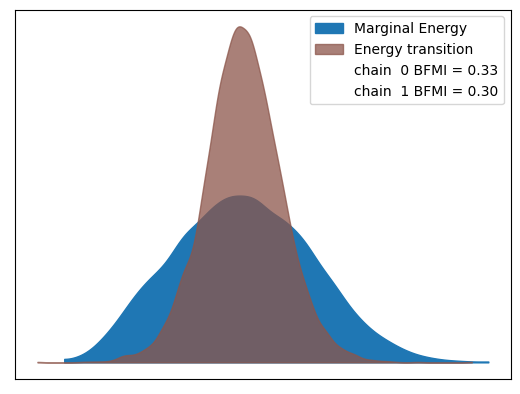

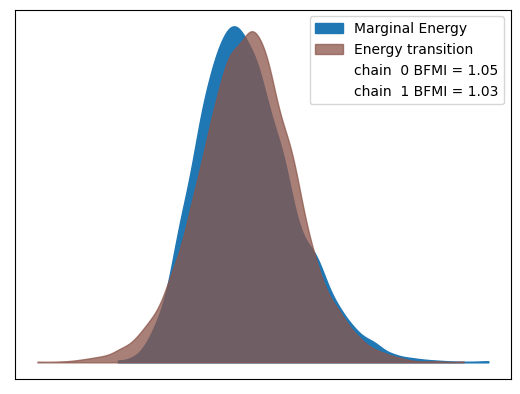

In [52]:
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

The first plot shows the marginal energy distribution and the energy transition distribution for the centered model, the second plot shows the distribution for the non centered model. For the first plot, we can see that the marginal and transition energy distributions do not overlap well (with low values of 0.33 and 0.3 for the BMFI), which is usually indicative of poor exploration and sampling efficiency by the algorithm. 

The plot for the non centered model shows a closer alignment between the energy transition and the marginal energy distribution. The BFMI values are  also around 1 for both chains which implies that the algorithm is efficiently exploring the parameter space and sampling from the target distribution.

Overall the diagnostic findings support our previous idea that the "uncentered" parameterizations enhanced the HMC algorithm's performance by removing potential issues in the posterior distribution, such as high curvature, which impedes effective sampling.